In [590]:
import json
from tld import get_fld
import csv
import os.path
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import re
from tld.exceptions import TldDomainNotFound, TldBadUrl
from datetime import datetime,timedelta
from itertools import chain
import pandas as pd

In [591]:
page_load_time_desktop=[]
page_load_time_mobile=[]
num_requests_desktop=[]
num_requests_mobile=[]
num_third_parties_desktop=[]
num_third_parties_mobile=[]
num_trackers_domain_desktop=[]
num_trackers_domain_mobile=[]
num_trackers_ent_desktop=[]
num_trackers_ent_mobile=[]


third_parties_desktop_list=[]
third_parties_mobile_list=[]
tracker_domain_desktop_list=[]
tracker_domain_mobile_list=[]
tracker_ent_desktop_list=[]
tracker_ent_mobile_list=[]

analysis_websites_desktop=[]
analysis_tranco_desktop=[]

analysis_websites_mobile=[]
analysis_tranco_mobile=[]

domain_not_found=[]

max_cookie_req_desk=[]
max_cookie_website_desk=[]
max_cookie_num_desk=[]
max_first_party_desk=[]

max_cookie_req_mob=[]
max_cookie_website_mob=[]
max_cookie_num_mob=[]
max_first_party_mob=[]

max_cookie_num_desk.append(0)
max_cookie_req_desk.append("NA")
max_cookie_website_desk.append("NA")
max_first_party_desk.append(True)
               

max_cookie_num_mob.append(0)
max_cookie_req_mob.append("NA")
max_cookie_website_mob.append("NA")
max_first_party_mob.append(True)


delta = timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)
top_cookies_desktop=["site1","site2","site3"]
top_cookies_mobile=["site1","site2","site3"]

top_lifespan_desktop=[delta,delta,delta]
top_lifespan_mobile=[delta,delta,delta]

redirect_desktop=[]
redirect_mobile=[]

               



In [592]:
#load the disconnect blocklist as top level domains
f = open('services.json') 
disconnect = json.load(f) 
disconnect=disconnect['categories']
disconnect_blocklist=[]
for entry in disconnect:
    domain_list=disconnect[entry]
    for item in domain_list:
        keys=item.keys()
        for key, value in item.items():
            for inner_key,inner_value in value.items():
                for element in inner_value:
                    if len(element)>1:
                        disconnect_blocklist.append(element)




In [593]:
f = open('domain_map.json') 
domain_map = json.load(f) 

In [594]:
def get_page_load_time(website):
    start_time=website['pageload_start_ts']
    end_time=website['pageload_end_ts']
    return end_time-start_time

In [595]:
def get_num_requests(website):
    return len(website['requests'])


In [596]:
def get_third_parties(website):
    third_party_domains=set()
    first_domain=website['domain']
    for req in website['requests']:
        try:
            req_domain=get_fld(req['request_url'])
        except TldDomainNotFound as e:
                domain_not_found.append(req['request_url'])

        if (req_domain!=first_domain):
             third_party_domains.add(req_domain)
    third_party_domains=list(third_party_domains)
    return third_party_domains

In [597]:
def get_tracker_domains(third_party_list):
    tracker_domains=set()
    for item in third_party_list:
        if item in disconnect_blocklist:
            tracker_domains.add(item)
    tracker_domains_to_list=(list)(tracker_domains)
    return tracker_domains_to_list

In [598]:
def get_tracker_entity (tracker_name):
    if tracker_name in domain_map.keys():
        return domain_map[tracker_name]['entityName']
    else:
        return "not found"
        

In [599]:
def get_cookie_count(cookie_header):
    cookies=cookie_header.split(";")
    return len(cookies)


In [600]:
def insert(list1, var, i):
    new_list = list1[:i]
    new_list.append(var)
    new_list.extend(list1[i:])
    return new_list

In [601]:

def check_max_cookies(website,type):
    request_website=website['domain']
    for req in website['requests']:
        hostname=req['request_url']
        header=req['request_headers']
        if ('cookie' in header.keys() or 'Cookie' in header.keys()):
            if ('cookie' in header.keys()):
                cookies=header['cookie']
            else:
                cookies=header['Cookie']
            count=get_cookie_count(cookies)
            try:
                req_domain=get_fld(hostname)
            except TldDomainNotFound as e:
                    party=False
            if (req_domain!=request_website):
                party=False
            else: 
                party=True
            if (type=="desktop"):
                if (count>max_cookie_num_desk[0]):
                    max_cookie_req_desk[0]=hostname
                    max_cookie_website_desk[0]=request_website
                    max_cookie_num_desk[0]=count
                    max_first_party_desk[0]=party
               

            else:
                if (count>max_cookie_num_mob[0]):
                    max_cookie_req_mob[0]=hostname
                    max_cookie_website_mob[0]=request_website
                    max_cookie_num_mob[0]=count
                    max_first_party_mob[0]=party
    

In [602]:
def get_cookie_lifespan(set_cookie_header):
    cookies=set_cookie_header.split(";")
    t= timedelta(days=0,seconds=0,microseconds=0,milliseconds=0,minutes=0,hours=0,weeks=0)

    if "comboid" not in set_cookie_header:
        for s in cookies: 
            if (("Expires" in s or "expires" in s)):
                if ('=' in s):
                    s=s.split("=")
                    try:
                        expiry=datetime.strptime(s[1],"%a, %d-%b-%Y %H:%M:%S %Z")
                        lifespan=expiry-datetime.now()
                        return lifespan  
                    except ValueError:
                            try:
                                expiry=datetime.strptime(s[1],"%a, %d %b %Y %H:%M:%S %Z")
                                lifespan=expiry-datetime.now()
                                return lifespan  
                            except ValueError:
                                try:
                                    expiry=datetime.strptime(s[1],"%a, %d %b %y %H:%M:%S %Z")
                                    lifespan=expiry-datetime.now()
                                    return lifespan  
                                except ValueError:
                                    try:
                                        expiry=datetime.strptime(s[1],"%a, %d-%b-%y %H:%M:%S %Z")
                                        lifespan=expiry-datetime.now()
                                        return lifespan 
                                    except ValueError:
                                        try:
                                            expiry=datetime.strptime(s[1],"%A, %d-%b-%Y %H:%M:%S %Z")
                                            lifespan=expiry-datetime.now()
                                            return lifespan 
                                        except ValueError:
                                            print (s[1])

    else: 
        #print(cookies)
        return t
    return t

In [603]:
def check_cookies(website,type):
    for req in website['requests']:
        resp_header=req['response_headers']
        
        if ('set-cookie' in resp_header.keys() or 'Set-Cookie' in resp_header.keys()):
            if ('set-cookie' in resp_header.keys()):
                lifespan=get_cookie_lifespan(resp_header['set-cookie']) 
                header_name='set-cookie'
            else:      
                lifespan=get_cookie_lifespan(resp_header['Set-Cookie']) 
                header_name='Set-Cookie'
            if (type=="desktop"):
                if (lifespan>top_lifespan_desktop[2]):
                    if (lifespan>top_lifespan_desktop[1]):
                        if(lifespan>top_lifespan_desktop[0]):
                            top_lifespan_desktop[2]=top_lifespan_desktop[1]
                            top_lifespan_desktop[1]=top_lifespan_desktop[0]
                            top_lifespan_desktop[0]=lifespan

                            top_cookies_desktop[2]=top_cookies_desktop[1]
                            top_cookies_desktop[1]=top_cookies_desktop[0]
                            top_cookies_desktop[0]=resp_header[header_name]
                            
                        else:
                            top_lifespan_desktop[2]=top_lifespan_desktop[1]
                            top_lifespan_desktop[1]=lifespan
                            top_cookies_desktop[2]=top_cookies_desktop[1]
                            top_cookies_desktop[1]=resp_header[header_name]



                    else:
                        top_lifespan_desktop[2]=lifespan
                        top_cookies_desktop[2]=resp_header[header_name]

                        
            else:
                    if (lifespan>top_lifespan_mobile[2]):
                        if (lifespan>top_lifespan_mobile[1]):
                            if(lifespan>top_lifespan_mobile[0]):
                                top_lifespan_mobile[2]=top_lifespan_mobile[1]
                                top_lifespan_mobile[1]=top_lifespan_mobile[0]
                                top_lifespan_mobile[0]=lifespan

                                top_cookies_mobile[2]=top_cookies_mobile[1]
                                top_cookies_mobile[1]=top_cookies_mobile[0]
                                top_cookies_mobile[0]=resp_header[header_name]
                            else:
                                top_lifespan_mobile[2]=top_lifespan_mobile[1]
                                top_lifespan_mobile[1]=lifespan

                                top_cookies_mobile[2]=top_cookies_desktop[1]
                                top_cookies_mobile[1]=resp_header[header_name]
                        else:
                                top_lifespan_mobile[2]=lifespan
                                
                                top_cookies_mobile[2]=resp_header[header_name]
   

In [604]:
def check_redirection(website,type):
    for req in website['requests']:
        req_url=req['request_url']
        resp_header=req['response_headers']
        if "location" in resp_header.keys():
            loc=resp_header['location']
            try:
                req_domain=get_fld(req_url)
                loc_domain=get_fld(loc)
                if req_domain is not None and loc_domain is not None:
                    if (req_domain!=loc_domain):
                            if loc_domain in disconnect_blocklist or req_domain in disconnect_blocklist:
                                redirect_pair=(req_domain,loc_domain)
                                if (type=="desktop"):
                                    redirect_desktop.append(redirect_pair)
                                else:
                                    redirect_mobile.append(redirect_pair)

            except TldDomainNotFound as e:
                    print ("Not a Domain")
                    print(req_url)
                    print(loc)
            except TldBadUrl as e:
                    print("Bad URL")
                    print (req_url)
                    print (loc)
            
            

In [605]:
urls=[]
tranco_rank=[]
with open('tranco-top-500-safe.csv') as file:
                data = csv.reader(file,delimiter=',')
                for url_data in data:
                    urls.append(url_data[1])
                    tranco_rank.append(url_data[0])
urls.remove("domain")
tranco_rank.remove("tranco_rank")

In [606]:
def get_tranco_rank(website_name):
    index=urls.index(website_name)
    return tranco_rank[index]

In [607]:
def get_crawl_data(type):
    for entry in urls:
        file_name='analysis/'+entry+'_'+type+'.json'
        if (os.path.exists(file_name)):
            current= open(file_name) 
            website_dict = json.load(current)
            page_load=get_page_load_time(website_dict)
            req_count=get_num_requests(website_dict)
            third_parties=get_third_parties(website_dict)
            tracker_entities=set()
            tracker_domains=get_tracker_domains(third_parties)
            for tracker in tracker_domains:
                tracker_entities.add(get_tracker_entity(tracker))
            tracker_entities=list(tracker_entities)

            if (type=='desktop'):
                page_load_time_desktop.append(page_load)
                num_requests_desktop.append(req_count)
                for domain in third_parties:
                    third_parties_desktop_list.append(domain)
                
                for t in tracker_domains:
                    tracker_domain_desktop_list.append(t)
                
                for e in tracker_entities:
                    tracker_ent_desktop_list.append(e)

                num_third_parties_desktop.append(len(third_parties))
                num_trackers_domain_desktop.append(len(tracker_domains))
                num_trackers_ent_desktop.append(len(tracker_entities))

                analysis_tranco_desktop.append(get_tranco_rank(website_dict['domain']))
                check_max_cookies(website_dict,"desktop")
                check_cookies(website_dict,"desktop")
                check_redirection(website_dict,"desktop")

                
                
            else: 
                page_load_time_mobile.append(page_load)
                num_requests_mobile.append(req_count)
                for domain in third_parties:
                    third_parties_mobile_list.append(domain)
                
                for t in tracker_domains:
                    tracker_domain_mobile_list.append(t)
                
                for e in tracker_entities:
                    tracker_ent_mobile_list.append(e)

                num_third_parties_mobile.append(len(third_parties))
                num_trackers_domain_mobile.append(len(tracker_domains))
                num_trackers_ent_mobile.append(len(tracker_entities))
                analysis_tranco_mobile.append(get_tranco_rank(website_dict['domain']))
                check_max_cookies(website_dict,"mobile")
                check_cookies(website_dict,"mobile")
                check_redirection(website_dict,"mobile")

    


In [608]:
get_crawl_data("desktop")
get_crawl_data("mobile")

Bad URL
https://sb.scorecardresearch.com/p?c1=2&c2=7241469&c5=2023538075&c7=https%3A%2F%2Fwww.yahoo.com%2F&c14=-1&c8=Yahoo%20%7C%20Mail%2C%20Weather%2C%20Search%2C%20Politics%2C%20News%2C%20Finance%2C%20Sports%20%26%20Videos&c9=https%3A%2F%2Fconsent.yahoo.com%2F&gdpr=1&gdpr_consent=CPZ_RYAPZ_RYAAOACBENCRCoAP_AAH_AACiQIlNd_X__bX9n-_7_7ft0cY1f9_r3r-QzjgfNs-8F3L_W_L0X32E7NF36pq4KuR4ku3bBIQFtHMnUTUmxaolVrzHsak2cpyNKI7LkknsZe2dYGH9Pn9lD-YKZ7_5___f53T___9_-39z3_9f___d9_-__-vjfV599n_v9fV_7_9nf_____-_-___4IQQ_AJMNS8gC7EscGTSMIoQQIwrCQqAUAFFAMLRFYAODgp2VgEuoIWACAVARgRAgxBRgwCAAACAJCIgJACwQCIAiAQAAgARAIQAETAILACwMAgAFANCxACgAECQgyICI5TAgIkSiglsrEEoK9jTCAOssAKBRGRUACJAAASAgJCwcxwBICXCyQJMULwAw0AGAAIIlCIAMAAQRKFQAYAAgiUA&ns_c=UTF-8&ns__t=1654298128383
/p2?c1=2&c2=7241469&c5=2023538075&c7=https%3A%2F%2Fwww.yahoo.com%2F&c14=-1&c8=Yahoo%20%7C%20Mail%2C%20Weather%2C%20Search%2C%20Politics%2C%20News%2C%20Finance%2C%20Sports%20%26%20Videos&c9=https%3A%2F%2Fconsent.yahoo.com%2F&gdpr=1&gdpr_consent=CPZ_RY

In [609]:
def generate_box_plot(data_desktop,data_mobile,plot_name,ylabel):
        data= [data_desktop, data_mobile]
        label = ['Crawl Desktop', 'Crawl Mobile']
        fig, (ax1) = plt.subplots(nrows=1, figsize=(9, 4))

        bplot = ax1.boxplot(data,
                        vert=True,  # vertical box alignment
                        patch_artist=True,  # fill with color
                        labels=label)  # will be used to label x-ticks
        colors = ['pink', 'lightblue']
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_facecolor(color)

        ax1.yaxis.grid(True)
        ax1.set_xlabel('Type')
        ax1.set_ylabel(ylabel)
        ax1.set_title(plot_name)

        plt.savefig(plot_name+'.jpg')
        #plt.show()

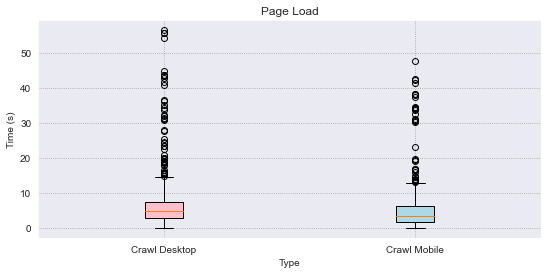

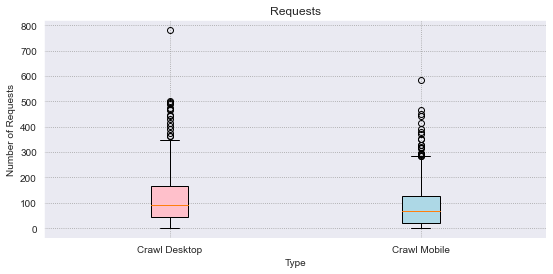

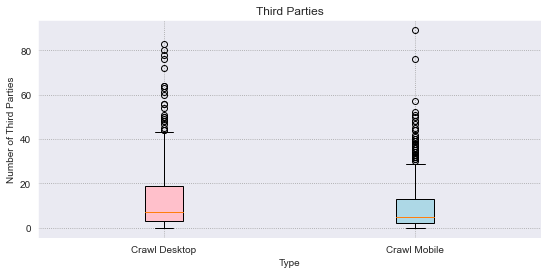

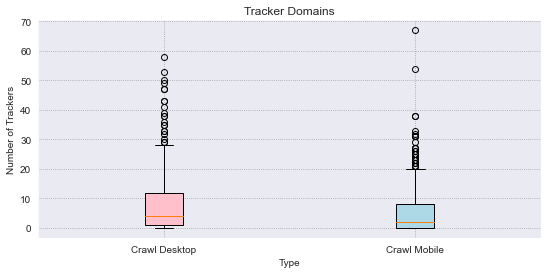

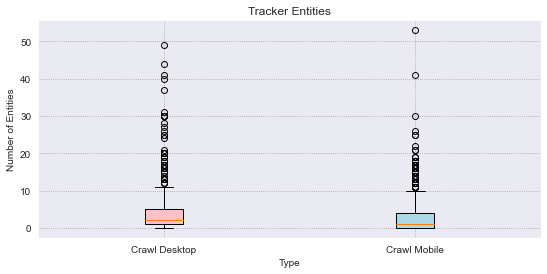

In [610]:

generate_box_plot(page_load_time_desktop,page_load_time_mobile,"Page Load","Time (s)")
generate_box_plot(num_requests_desktop,num_requests_mobile,"Requests","Number of Requests")
generate_box_plot(num_third_parties_desktop,num_third_parties_mobile,"Third Parties","Number of Third Parties")
generate_box_plot(num_trackers_domain_desktop,num_trackers_domain_mobile,"Tracker Domains","Number of Trackers")
generate_box_plot(num_trackers_ent_desktop,num_trackers_ent_mobile,"Tracker Entities","Number of Entities")



In [611]:
page_load_time_desktop=np.array(page_load_time_desktop)
page_load_time_mobile=np.array(page_load_time_mobile)

num_requests_desktop=np.array(num_requests_desktop)
num_requests_mobile=np.array(num_requests_mobile)

num_third_parties_desktop=np.array(num_third_parties_desktop)
num_third_parties_mobile=np.array(num_third_parties_mobile)

num_trackers_domain_desktop=np.array(num_trackers_domain_desktop)
num_trackers_domain_mobile=np.array(num_trackers_domain_mobile)

num_trackers_ent_desktop=np.array(num_trackers_ent_desktop)
num_trackers_ent_mobile=np.array(num_trackers_ent_mobile)

In [612]:
page_load_time_desktop_stats=[np.min(page_load_time_desktop),np.max(page_load_time_desktop),np.median(page_load_time_desktop)]
page_load_time_mobile_stats=[np.min(page_load_time_mobile),np.max(page_load_time_mobile),np.median(page_load_time_mobile)]

num_requests_desktop_stats=[np.min(num_requests_desktop),np.max(num_requests_desktop),np.median(num_requests_desktop)]
num_requests_mobile_stats=[np.min(num_requests_mobile),np.max(num_requests_mobile),np.median(num_requests_mobile)]

num_third_parties_desktop_stats=[np.min(num_third_parties_desktop),np.max(num_third_parties_desktop),np.median(num_third_parties_desktop)]
num_third_parties_mobile_stats=[np.min(num_third_parties_mobile),np.max(num_third_parties_mobile),np.median(num_third_parties_mobile)]

num_trackers_domain_desktop_stats=[np.min(num_trackers_domain_desktop),np.max(num_trackers_domain_desktop),np.median(num_trackers_domain_desktop)]
num_trackers_domain_mobile_stats=[np.min(num_trackers_domain_mobile),np.max(num_trackers_domain_mobile),np.median(num_trackers_domain_mobile)]

num_trackers_ent_desktop_stats=[np.min(num_trackers_ent_desktop),np.max(num_trackers_ent_desktop),np.median(num_trackers_ent_desktop)]
num_trackers_ent_mobile_stats=[np.min(num_trackers_ent_mobile),np.max(num_trackers_ent_mobile),np.median(num_trackers_ent_mobile)]


In [613]:
print("page load desktop",page_load_time_desktop_stats)
print("page load mobile",page_load_time_mobile_stats)

print("requests desktop",num_requests_desktop_stats)
print("requests mobile",num_requests_mobile_stats)

print("third parties desktop",num_third_parties_desktop_stats)
print("third parties mobile",num_third_parties_mobile_stats)

print("trackers desktop",num_trackers_domain_desktop_stats)
print("trackers mobile",num_trackers_domain_mobile_stats)

print("Tracker entities",num_trackers_ent_desktop_stats)
print("Tracker entities",num_trackers_ent_mobile_stats)






page load desktop [0.05898785591125488, 56.40058660507202, 4.842140555381775]
page load mobile [0.13604307174682617, 47.76420712471008, 3.4975976943969727]
requests desktop [1, 780, 91.0]
requests mobile [1, 585, 66.0]
third parties desktop [0, 83, 7.0]
third parties mobile [0, 89, 5.0]
trackers desktop [0, 58, 4.0]
trackers mobile [0, 67, 2.0]
Tracker entities [0, 49, 2.0]
Tracker entities [0, 53, 1.0]


In [614]:
def get_top_elements(domains,num):
    domains_count=dict(Counter(domains))
    domains_sorted = sorted(domains_count, key=domains_count.get, reverse=True)
    i=0
    for e in domains_sorted:
        print(e,domains_count[e])
        i=i+1
        if (i==num):
            return


In [615]:
print("*******************top five desktop domains*************")
get_top_elements(third_parties_desktop_list,5)
print("*******************top five mobile domains**************")
get_top_elements(third_parties_mobile_list,5)

*******************top five desktop domains*************
google.com 214
doubleclick.net 205
google-analytics.com 198
googletagmanager.com 186
google.nl 163
*******************top five mobile domains**************
google.com 169
doubleclick.net 163
google-analytics.com 151
googletagmanager.com 148
google.nl 118


In [616]:
print("*******************top five desktop trackers*************")
get_top_elements(tracker_domain_desktop_list,10)
print("*******************top five mobile trackers**************")
get_top_elements(tracker_domain_mobile_list,10)

*******************top five desktop trackers*************
google.com 214
doubleclick.net 205
google-analytics.com 198
google.nl 163
gstatic.com 122
facebook.com 110
facebook.net 99
googleadservices.com 89
googlesyndication.com 68
twitter.com 62
*******************top five mobile trackers**************
google.com 169
doubleclick.net 163
google-analytics.com 151
google.nl 118
gstatic.com 102
facebook.com 75
googleadservices.com 64
facebook.net 62
googlesyndication.com 52
scorecardresearch.com 48


In [617]:
print("*******************top five desktop entities*************")
get_top_elements(tracker_ent_desktop_list,5)
print("*******************top five mobile entities**************")
get_top_elements(tracker_ent_mobile_list,5)

*******************top five desktop entities*************
Google LLC 282
Facebook, Inc. 117
Microsoft Corporation 92
Adobe Inc. 74
Amazon Technologies, Inc. 68
*******************top five mobile entities**************
Google LLC 232
Facebook, Inc. 79
Microsoft Corporation 66
Amazon Technologies, Inc. 58
Adobe Inc. 53


In [618]:
def generate_scatter_plot(data_desktop,data_mobile,tranco_desktop,tranco_mobile,x_label,y_label):
    fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(24, 8))
    #ax1.yaxis.grid(True)
    #ax1.xaxis.grid(True)
    ax1.set_xlabel(x_label,fontsize=16)
    ax1.set_ylabel(y_label,fontsize=16)
    ax1.set_title("Crawl Desktop",fontsize=22)
    #sns.regplot(x=tranco_desktop, y=data_desktop, ax=ax1, marker='o', c='b', edgecolor='b')
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    sns.regplot(x=np.array(tranco_desktop,dtype='int'), y=np.array(data_desktop,dtype='int'), ax=ax1)
    #ax2.yaxis.grid(True)
    #ax2.xaxis.grid(True)
    ax2.set_xlabel(x_label,fontsize=16)
    ax2.set_ylabel(y_label,fontsize=16)
    ax2.set_title("Crawl Mobile",fontsize=22)
    #sns.regplot(x=tranco_mobile, y=data_mobile,ax=ax2, marker='o', c='b', edgecolor='b')
    sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
    sns.regplot(x=np.array(tranco_mobile,dtype='int'), y=np.array(data_mobile,dtype='int'), ax=ax2)
    plt.savefig(y_label+'.jpg')
    plt.show()

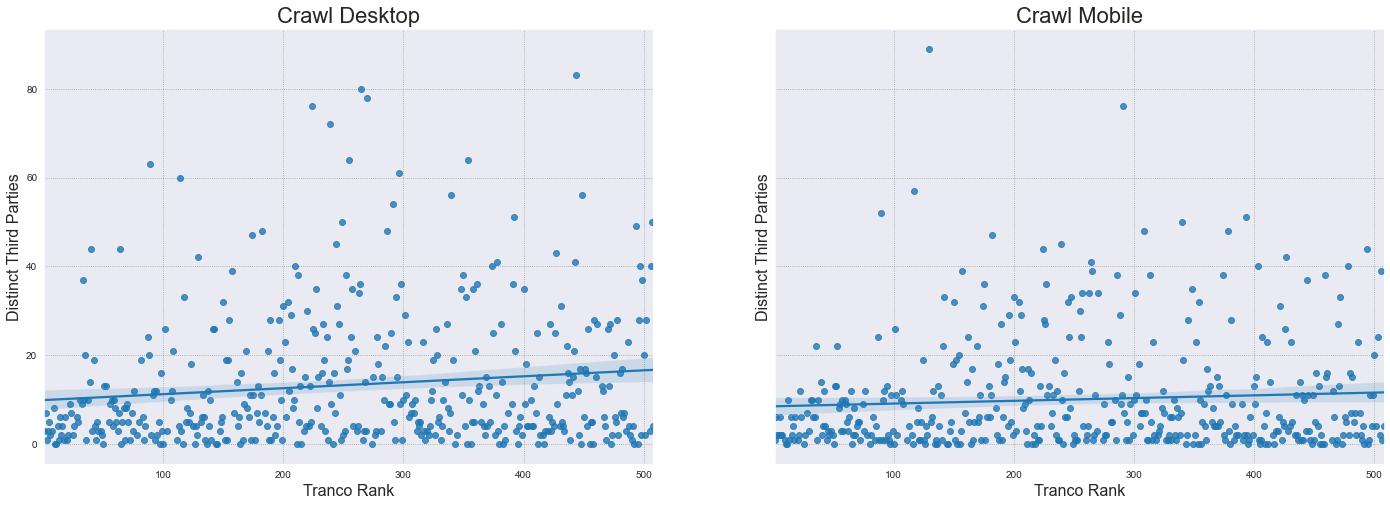

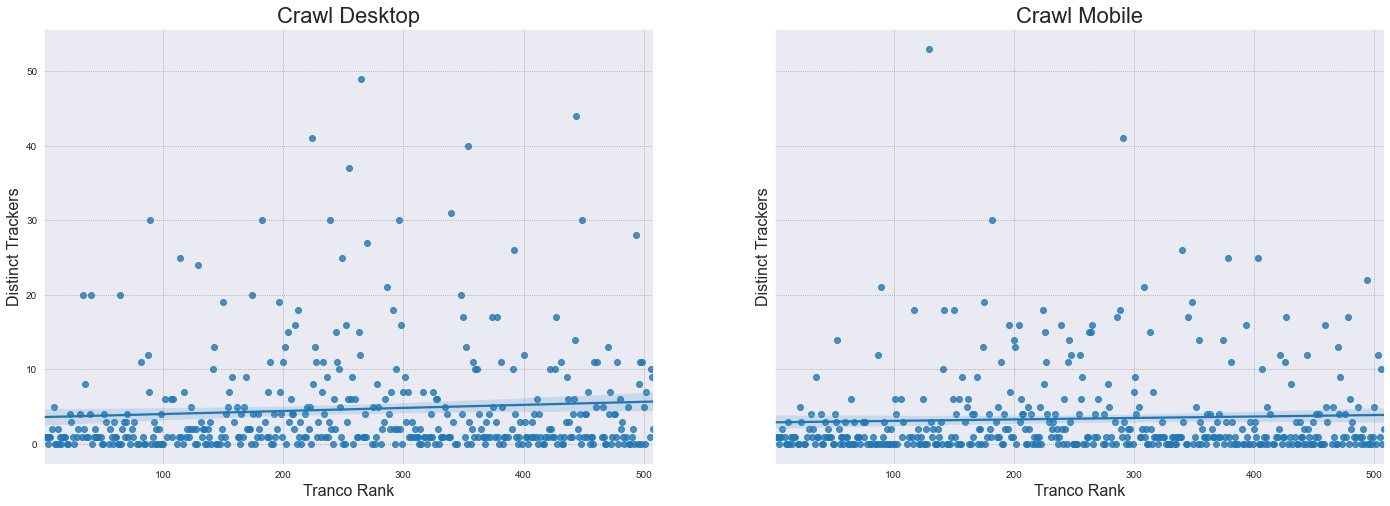

In [619]:
    generate_scatter_plot(num_third_parties_desktop,num_third_parties_mobile,analysis_tranco_desktop,analysis_tranco_mobile,"Tranco Rank","Distinct Third Parties")

    generate_scatter_plot(num_trackers_ent_desktop,num_trackers_ent_mobile,analysis_tranco_desktop,analysis_tranco_mobile,"Tranco Rank","Distinct Trackers")

In [620]:
print(domain_not_found)

['https://118.89.204.198/resolv?host=www.zhihu.com&os_type=web', 'https://103.44.59.54/3ea', 'https://118.26.32.19/3f0/hd.cloud.iqiyi.com/d?dn=cache.video.iqiyi.com&business=pcwPlayer&cross-domain=1', 'https://118.89.204.198/resolv?host=www.zhihu.com&os_type=web']


In [621]:
print("Request Hostname:",max_cookie_req_desk)
print("Request Website:",max_cookie_website_desk)
print("Number of Cookies:",max_cookie_num_desk)
print("First Party:",max_first_party_desk)

print("Request Hostname:",max_cookie_req_mob)
print("Request Website:",max_cookie_website_mob)
print("Number of Cookies:",max_cookie_num_mob)
print("First Party:",max_first_party_mob)


Request Hostname: ['https://www.telegraph.co.uk/customer/lib/onetap.js']
Request Website: ['telegraph.co.uk']
Number of Cookies: [41]
First Party: [True]
Request Hostname: ['https://www.telegraph.co.uk/martech/css/TGT-395--martech-overlay/style-general-soft-overlay.css']
Request Website: ['telegraph.co.uk']
Number of Cookies: [42]
First Party: [True]


In [622]:
print("******************TOP COOKIES DESKTOP*****************")
print(top_cookies_desktop)
print(top_lifespan_desktop)
print("******************TOP COOKIES MOBILE*****************")

print(top_cookies_mobile)
print(top_lifespan_mobile)

******************TOP COOKIES DESKTOP*****************
['Ecp_ClientId=2220604114001090588; domain=cnki.net; expires=Thu, 04-Jun-2122 03:40:20 GMT; path=/; secure', 'v=IylAE!$Dr69_qG2u$xs$; expires=Monday, 02-Nov-2099 00:00:00 GMT; path=/; domain=.mediav.com', 'v=J-ugI/>iJ@9_qG23Zen^; expires=Monday, 02-Nov-2099 00:00:00 GMT; path=/; domain=.mediav.com']
[datetime.timedelta(days=36522, seconds=19902, microseconds=266477), datetime.timedelta(days=28273, seconds=6684, microseconds=735747), datetime.timedelta(days=28273, seconds=6684, microseconds=735702)]
******************TOP COOKIES MOBILE*****************
['uid=8257ae0c081e497b92d87e50c8821041;domain=.xinhuanet.com;expires=Wednesday, 02-Nov-2099 00:00:00 GMT;path=/;', 'uid=eae5a7267a87470db283a1b84c656d51;domain=.xinhuanet.com;expires=Wednesday, 02-Nov-2099 00:00:00 GMT;path=/;', 'TMog=naca8f8f6d2934d2ab5106c97e368a0c901; Path=/; Domain=.investopedia.com; Expires=Thu, 22-Jun-2090 05:07:29 GMT; Max-Age=2147483647']
[datetime.timedelta(d

In [623]:
print(Counter(chain(redirect_desktop)))

print(Counter(chain(redirect_mobile)))


Counter({('doubleclick.net', 'google.com'): 103, ('google.com', 'google.nl'): 95, ('doubleclick.net', 'everesttech.net'): 60, ('google.com', 'doubleclick.net'): 42, ('clarity.ms', 'bing.com'): 28, ('bing.com', 'clarity.ms'): 27, ('doubleclick.net', 'pubmatic.com'): 27, ('mathtag.com', 'pubmatic.com'): 19, ('doubleclick.net', 'demdex.net'): 13, ('youtube.com', 'google.com'): 13, ('google.nl', 'doubleclick.net'): 12, ('pubmatic.com', 'doubleclick.net'): 9, ('de17a.com', 'pubmatic.com'): 9, ('adform.net', 'pubmatic.com'): 9, ('rlcdn.com', 'demdex.net'): 9, ('unrulymedia.com', '1rx.io'): 9, ('quantserve.com', 'pubmatic.com'): 8, ('bidr.io', 'company-target.com'): 6, ('yahoo.com', 'rubiconproject.com'): 6, ('doubleclick.net', 'casalemedia.com'): 6, ('mathtag.com', 'demdex.net'): 6, ('bidr.io', 'doubleclick.net'): 6, ('doubleclick.net', 'bidr.io'): 6, ('yahoo.com', 'pubmatic.com'): 6, ('fiftyt.com', 'pubmatic.com'): 6, ('adsrvr.org', 'rubiconproject.com'): 5, ('yahoo.com', 'demdex.net'): 5, 